In [1]:
import dask
import glob
import time
import random
import torch as py
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from multiprocessing import Pool, Manager
from matplotlib.ticker import FormatStrFormatter

In [2]:
# Load data
# --------------------------------------
ds1   = xr.open_dataset('/scratch/smata/data/ProcessedData_a0/second_pull/full_lidar.nc')
ds24  = xr.open_dataset('/scratch/smata/data/ProcessedData_a0/second_pull/full_4m_sonic.nc')
ds225 = xr.open_dataset('/scratch/smata/data/ProcessedData_a0/second_pull/full_25m_sonic.nc')
ds260 = xr.open_dataset('/scratch/smata/data/ProcessedData_a0/second_pull/full_60m_sonic.nc')
ds3   = xr.open_dataset('/scratch/smata/data/ProcessedData_a0/second_pull/full_stability.nc')
# ds4   = xr.open_dataset('/scratch/smata/data/ProcessedData_a0/second_pull/full_sonde.nc')

In [3]:
# Combine datasets on height dimension
# --------------------------------------
ds_combined = xr.concat([ds1, ds24, ds225, ds260], dim = 'height')
ds_combined = ds_combined.sortby('height')

In [4]:
# This deletes outlier heights from datasets
# --------------------------------------
del_heights = xr.open_dataset('/scratch/smata/data/ProcessedData_a0/second_pull/sgpdlprofwind4newsC1.c1.20210407.000054.nc')['height']
ds_combined = ds_combined.where(~ds_combined.height.isin(del_heights), drop = True)

In [6]:
# Remove outliers velocities
# --------------------------------------
for i in range(ds_combined.height.shape[0]):
    q90, q10 = np.nanpercentile(ds_combined['u'][i], [99.5, 0.5])
    ds_combined['u'][i] = ds_combined['u'][i].where((ds_combined['u'][i] >= q10) & (ds_combined['u'][i] <= q90), np.nan)
    q90, q10 = np.nanpercentile(ds_combined['v'][i], [99.5, 0.5])
    ds_combined['v'][i] = ds_combined['v'][i].where((ds_combined['v'][i] >= q10) & (ds_combined['v'][i] <= q90), np.nan)

In [7]:
# Interpolate to regular grid
# --------------------------------------
ds_combined = ds_combined.interp(height = np.arange(10, 2010, 10))

In [11]:
# Compute common time axis and cyclical time variables
# --------------------------------------

ref_date      = np.datetime64('2015-07-23T00:00:00.000000')

new_ref_times = np.empty(ds_combined.time.shape, dtype = 'datetime64[ns]')
hr_per_day    = np.zeros(new_ref_times.shape)
day_per_yr    = np.zeros(new_ref_times.shape)
times         = ds_combined.time.values

for i in range(ds_combined.time.shape[0]):
    new_ref_times[i] = np.datetime64((pd.Timestamp(ref_date) + pd.Timedelta(times[i], 'D')).round('min'))
    hr_per_day[i]    = pd.Timestamp(new_ref_times[i]).hour + pd.Timestamp(new_ref_times[i]).minute/60
    day_per_yr[i]    = new_ref_times[i].astype('datetime64[D]').astype(datetime).timetuple().tm_yday

ds_combined['hr_per_day_c'] = (('time'), np.cos(hr_per_day))
ds_combined['hr_per_day_s'] = (('time'), np.sin(hr_per_day))
ds_combined['day_per_yr_c'] = (('time'), np.cos(day_per_yr))
ds_combined['day_per_yr_s'] = (('time'), np.sin(day_per_yr))

In [ ]:
# Generate copy/paste list of data bounds
# --------------------------------------
print(str(ds_combined['u'].min(skipna=True).values) + ',')
print(str(ds_combined['u'].max(skipna=True).values) + ',')
print(str(ds_combined['v'].min(skipna=True).values) + ',')
print(str(ds_combined['v'].max(skipna=True).values) + ',')
print(str(ds_combined['hr_per_day_c'].min(skipna=True).values) + ',')
print(str(ds_combined['hr_per_day_c'].max(skipna=True).values) + ',')
print(str(ds_combined['hr_per_day_s'].min(skipna=True).values) + ',')
print(str(ds_combined['hr_per_day_s'].max(skipna=True).values) + ',')
print(str(ds_combined['day_per_yr_c'].min(skipna=True).values) + ',')
print(str(ds_combined['day_per_yr_c'].max(skipna=True).values) + ',')
print(str(ds_combined['day_per_yr_s'].min(skipna=True).values) + ',')
print(str(ds_combined['day_per_yr_s'].max(skipna=True).values) + ',')

In [ ]:
# Generate training, validation, and testing files in parallel
# --------------------------------------

if __name__ == '__main__':

    avg_u    = ds_combined['u'].mean(skipna=True)
    avg_v    = ds_combined['v'].mean(skipna=True)
    avg_hpdc = ds_combined['hr_per_day_c'].mean(skipna=True)
    avg_hpds = ds_combined['hr_per_day_s'].mean(skipna=True)
    avg_dpyc = ds_combined['day_per_yr_c'].mean(skipna=True)
    avg_dpys = ds_combined['day_per_yr_s'].mean(skipna=True)

    shared_trv = []
    shared_te  = []

    day = np.arange(0, np.floor(np.max(ds_combined.time)), 1)
    # day = np.arange(0, 20, 1)
    te_index = np.random.choice(day, int(np.floor(0.2 * len(day))), replace=False)

    def generate_file(day_value, te_index, shared_te, shared_trv):

        extract_u    = ds_combined.u.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
        extract_v    = ds_combined.v.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

        extract_hpdc = ds_combined.hr_per_day_c.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
        extract_hpds = ds_combined.hr_per_day_s.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

        extract_dpyc = ds_combined.day_per_yr_c.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values
        extract_dpys = ds_combined.day_per_yr_s.where((ds_combined.time >= day_value) & (ds_combined.time < (day_value + 1)), drop=True).values

        extract_u[np.isnan(extract_u)]       = avg_u
        extract_v[np.isnan(extract_v)]       = avg_v
        extract_hpdc[np.isnan(extract_hpdc)] = avg_hpdc
        extract_hpds[np.isnan(extract_hpds)] = avg_hpds
        extract_dpyc[np.isnan(extract_dpyc)] = avg_dpyc
        extract_dpys[np.isnan(extract_dpys)] = avg_dpys

        array_u      = extract_u.T
        array_v      = extract_v.T

        array_hpdc   = (np.ones((extract_u.shape)) * extract_hpdc).T
        array_hpds   = (np.ones((extract_u.shape)) * extract_hpds).T
        array_dpyc   = (np.ones((extract_u.shape)) * extract_dpyc).T
        array_dpys   = (np.ones((extract_u.shape)) * extract_dpys).T

        tensor = py.stack([py.Tensor(array_u), py.Tensor(array_v), py.Tensor(array_hpdc), py.Tensor(array_hpds), py.Tensor(array_dpyc), py.Tensor(array_dpys)])

        if tensor.shape[1] == 96:

            path = '/scratch/smata/data/ProcessedData_a0/train_val_test/day_%04d.pt' % day_value

            if day_value in te_index:
                shared_te.append(path + '\n')
            else:
                shared_trv.append(path + '\n')

            py.save({'x': tensor, 'y': tensor}, path)
        else:
            pass
        
    start_time = time.time()

    manager    = Manager()
    shared_trv = manager.list()
    shared_te  = manager.list()

    # Parallel processing
    with Pool(48) as pool:
        pool.starmap(generate_file, [(d, te_index, shared_te, shared_trv) for d in day])

    sorted_trv = sorted(shared_trv)
    sorted_te  = sorted(shared_te)

    with open('./train_and_val.flist', 'a') as file_trv, open('./test.flist', 'a') as file_te:
        file_trv.writelines(sorted_trv)
        file_te.writelines(sorted_te)

    end_time = time.time()

    print(f"Time: {end_time - start_time:.2f} seconds")

### Various plotting and QC scripts

In [8]:
# # Plot time-varying profiles
# # --------------------------------------

# fig,ax = plt.subplots(figsize = (15, 4))

# cntf = ax.pcolormesh(ds_combined['time'], ds_combined['height'], ds_combined['u'], vmin = -8, vmax = 15)
# ax.set_ylabel("$z$ [m]", color = 'w')
# ax.set_ylim([0, 2000])

# cb_ax = fig.add_axes([0.905, 0.1125, 0.015, 0.768])
# cbar = fig.colorbar(cntf, orientation='vertical', cax = cb_ax)
# cbar.set_label('$u$ component [m/s]', rotation = 270, labelpad = 15, color = 'k')
# # cbar.outline.set_color('white')
# # cbar.ax.yaxis.set_tick_params(color = 'w')
# # plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'w')

# # for spine in ax.spines.values():
#     # spine.set_edgecolor('w')

# ax.set_xticks((np.array([360, 725, 1090, 1440, 1800, 2160, 2520, 2880, 3240]) - 204), ["2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"])
# # ax.set_title(f'Profiles: {common_time.shape[0]:,}', color = 'w')

# # ax.tick_params(axis = 'x', colors = 'w')
# # ax.tick_params(axis = 'y', colors = 'w')

In [9]:
# # Plot time-varying profiles
# # --------------------------------------

# fig,ax = plt.subplots(figsize = (15, 4))

# cntf = ax.pcolormesh(ds_combined['time'], ds_combined['height'], ds_combined['v'], vmin = -8, vmax = 20)
# ax.set_ylabel("$z$ [m]", color = 'w')
# ax.set_ylim([0, 2000])

# cb_ax = fig.add_axes([0.905, 0.1125, 0.015, 0.768])
# cbar = fig.colorbar(cntf, orientation='vertical', cax = cb_ax)
# cbar.set_label('$v$ component [m/s]', rotation = 270, labelpad = 15, color = 'k')
# # cbar.outline.set_color('white')
# # cbar.ax.yaxis.set_tick_params(color = 'w')
# # plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'w')

# # for spine in ax.spines.values():
#     # spine.set_edgecolor('w')

# ax.set_xticks((np.array([360, 725, 1090, 1440, 1800, 2160, 2520, 2880, 3240]) - 204), ["2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"])
# # ax.set_title(f'Profiles: {common_time.shape[0]:,}', color = 'w')

# # ax.tick_params(axis = 'x', colors = 'w')
# # ax.tick_params(axis = 'y', colors = 'w')

In [10]:
# # Plot time-varying profiles
# # --------------------------------------

# fig,ax = plt.subplots(figsize = (15, 6))

# cntf = ax.pcolormesh(ds_combined['time'], ds_combined['height'], (ds_combined['v']**2 + ds_combined['u']**2)**(0.5), vmin = 0, vmax = 20)
# ax.set_ylabel("$z$ [m]", color = 'k')
# ax.set_ylim([0, 2000])

# cb_ax = fig.add_axes([0.905, 0.1125, 0.015, 0.768])
# cbar = fig.colorbar(cntf, orientation='vertical', cax = cb_ax)
# cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 15, color = 'k')
# # cbar.outline.set_color('white')
# # cbar.ax.yaxis.set_tick_params(color = 'w')
# # plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'w')

# # for spine in ax.spines.values():
#     # spine.set_edgecolor('w')

# ax.set_xticks((np.array([360, 725, 1090, 1440, 1800, 2160, 2520, 2880, 3240]) - 204), ["2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"])
# # ax.set_title(f'Profiles: {common_time.shape[0]:,}', color = 'w')

# # ax.tick_params(axis = 'x', colors = 'w')
# # ax.tick_params(axis = 'y', colors = 'w')

# plt.savefig('./large_data.png', dpi = 700, bbox_inches = 'tight', transparent = True)


In [12]:
# # Confirm time axes are correct
# # --------------------------------------

# fig,ax = plt.subplots(figsize = (7, 7))

# # ax[0].plot(times, hr_per_day)
# ax.hist(hr_per_day, bins = 46, edgecolor = 'black')
# # ax.set_xlim([0, 23])
# # x[0].plot(range(len(times)), hr_per_day)
# ax.set_xlabel('Fractional hour of day')
# ax.set_ylabel('Count')

In [13]:
# # Plot rectified wind profiles
# # --------------------------------------

# plt.style.use('dark_background')

# fig,ax = plt.subplots(3, 1, figsize = (15, 8), sharex = True)

# cntf = ax[0].pcolormesh(ds_combined['time'], ds_combined['height'], ds_combined['u'], vmin = -15, vmax = 15,  cmap = 'twilight_shifted')
# cbar = plt.colorbar(cntf)
# cbar.set_label('$u$ component [m/s]', rotation = 270, labelpad = 20)
# ax[0].set_ylabel("$z$ [m]")
# ax[0].set_ylim([0, 2000])
# ax[0].get_xaxis().set_ticks([])

# cntf = ax[1].pcolormesh(ds_combined['time'], ds_combined['height'], ds_combined['v'], vmin = -15, vmax = 15,  cmap = 'twilight_shifted')
# cbar = plt.colorbar(cntf)
# cbar.set_label('$v$ component [m/s]', rotation = 270, labelpad = 20)
# ax[1].set_ylabel("$z$ [m]")
# ax[1].set_ylim([0, 2000])
# ax[1].get_xaxis().set_ticks([])

# cntf = ax[2].pcolormesh(ds_combined['time'], ds_combined['height'], (ds_combined['u']**2 + ds_combined['v']**2)**(1/2), vmin = 0, vmax = 20, cmap = 'viridis')
# cbar = plt.colorbar(cntf)
# cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 20)
# # ax[2].set_xlabel("Profile index [-]")
# ax[2].set_ylabel("$z$ [m]")
# ax[2].set_ylim([0, 2000])
# ax[2].set_xticks((np.array([360, 725, 1090, 1440, 1800, 2160, 2520, 2880, 3240]) - 204), ["2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"])

# plt.savefig('./large_data_uv.png', dpi = 750, bbox_inches = 'tight', transparent = True)


In [14]:
# day = 5

# extract_u = ds_combined.u.where((ds_combined.time >= day) & (ds_combined.time < (day + 1)), drop=True)
# extract_v = ds_combined.v.where((ds_combined.time >= day) & (ds_combined.time < (day + 1)), drop=True)

# extract_t = ds_combined.time.where((ds_combined.time >= day) & (ds_combined.time < (day + 1)), drop=True)

# fig,ax = plt.subplots(figsize = (6, 8))

# cntf = ax.pcolormesh(extract_t, ds_combined['height'], (extract_u**(2) + extract_v)**(0.5), vmin = 0, vmax = 15)
# ax.set_ylabel("$z$ [m]")
# ax.set_xlabel("Day Index [-]")
# ax.set_ylim([0, 2000])

# cb_ax = fig.add_axes([0.91, 0.11, 0.025, 0.77])
# cbar = fig.colorbar(cntf, orientation='vertical', cax = cb_ax)
# cbar.set_label('Wind Speed [m/s]', rotation = 270, labelpad = 12, color = 'k')

# plt.savefig('./large_data.png', dpi = 700, bbox_inches = 'tight', transparent = True)

In [ ]:
# # Generate training, validation, and testing files in serial
# # --------------------------------------

# avg_u    = ds_combined['u'].mean(skipna=True)
# avg_v    = ds_combined['v'].mean(skipna=True)
# avg_hpdc = ds_combined['hr_per_day_c'].mean(skipna=True)
# avg_hpds = ds_combined['hr_per_day_s'].mean(skipna=True)
# avg_dpyc = ds_combined['day_per_yr_c'].mean(skipna=True)
# avg_dpys = ds_combined['day_per_yr_s'].mean(skipna=True)

# file_trv = open('./train_and_val.flist', 'a')
# file_te  = open('./test.flist', 'a')

# day = np.arange(0, np.floor(np.max(ds_combined.time)), 1)
# # day = np.arange(0, 20, 1)
# te_index = np.random.choice(day, int(np.floor(0.2 * len(day))), replace=False)

# for i in range(len(day)):

#     extract_u    = ds_combined.u.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values
#     extract_v    = ds_combined.v.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values

#     extract_hpdc = ds_combined.hr_per_day_c.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values
#     extract_hpds = ds_combined.hr_per_day_s.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values

#     extract_dpyc = ds_combined.day_per_yr_c.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values
#     extract_dpys = ds_combined.day_per_yr_s.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True).values

#     extract_u[np.isnan(extract_u)]       = avg_u
#     extract_v[np.isnan(extract_v)]       = avg_v
#     extract_hpdc[np.isnan(extract_hpdc)] = avg_hpdc
#     extract_hpds[np.isnan(extract_hpds)] = avg_hpds
#     extract_dpyc[np.isnan(extract_dpyc)] = avg_dpyc
#     extract_dpys[np.isnan(extract_dpys)] = avg_dpys

#     array_u      = extract_u.T
#     array_v      = extract_v.T

#     array_hpdc   = (np.ones((extract_u.shape)) * extract_hpdc).T
#     array_hpds   = (np.ones((extract_u.shape)) * extract_hpds).T
#     array_dpyc   = (np.ones((extract_u.shape)) * extract_dpyc).T
#     array_dpys   = (np.ones((extract_u.shape)) * extract_dpys).T

#     tensor = py.stack([py.Tensor(array_u), py.Tensor(array_v), py.Tensor(array_hpdc), py.Tensor(array_hpds), py.Tensor(array_dpyc), py.Tensor(array_dpys)])

#     if i in te_index:
#         path = '/scratch/smata/data/ProcessedData_a0/test/day_%04d.pt' % i
#         file_te.write(path + '\n')
#     else:
#         path = '/scratch/smata/data/ProcessedData_a0/train_and_validation/day_%04d.pt' % i
#         file_trv.write(path + '\n')

#     py.save({'x': tensor, 'y': tensor}, '/scratch/smata/data/ProcessedData_a0/train_val_test/day_%04d.pt' % i)

# file_trv.close()
# file_te.close()

In [57]:
# Generate movie of snapshots
# --------------------------------------
day = np.arange(1, 11, 1/96)

for i in range(len(day)):

    extract_u = ds_combined.u.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True)
    extract_v = ds_combined.v.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True)

    extract_t = ds_combined.time.where((ds_combined.time >= day[i]) & (ds_combined.time < (day[i] + 1)), drop=True)

    plt.style.use('dark_background')

    fig,ax = plt.subplots(figsize = (6, 8))

    cntf = ax.pcolormesh(extract_t, ds_combined['height'], (extract_u**(2) + extract_v)**(0.5), vmin = 0, vmax = 15)
    ax.set_ylabel("$z$ [m]")
    ax.set_xlabel("Day Index [-]")
    ax.set_ylim([0, 2000])

    cb_ax = fig.add_axes([0.91, 0.11, 0.025, 0.77])
    cbar = fig.colorbar(cntf, orientation='vertical', cax = cb_ax)
    cbar.set_label('Wind Speed [m/s]', rotation = 270, labelpad = 12)

    plt.savefig('./snapshots/snap_%04d.png' % i, dpi = 420, bbox_inches = 'tight', transparent = False)

    plt.close()

In [6]:
# Inspect sample files
# --------------------------------------
mmm = py.load('/scratch/smata/diffusion_test/data/files/train/sample_0024_00.pt')

type(mmm)

mmm.keys()

mmm['x']

mmm['x'].shape

mmm['x'][0,:,:]

/tmp/ipykernel_2083720/2303327131.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mmm = py.load('/scratch/smata/diffusion_test/data/files/train/sample_0024_00.pt')


tensor([[9.2516, 9.2516, 9.2516,  ..., 9.2516, 9.2516, 9.2516],
        [9.2516, 9.2516, 9.2516,  ..., 9.2516, 9.2516, 9.2516],
        [9.2516, 9.2516, 9.2516,  ..., 9.2516, 9.2516, 9.2516],
        ...,
        [9.2516, 9.2516, 9.2516,  ..., 9.2516, 9.2516, 9.2516],
        [9.2516, 9.2516, 9.2516,  ..., 9.2516, 9.2516, 9.2516],
        [9.2516, 9.2516, 9.2516,  ..., 9.2516, 9.2516, 9.2516]])

Text(0.5, 0, 'Day Index [-]')

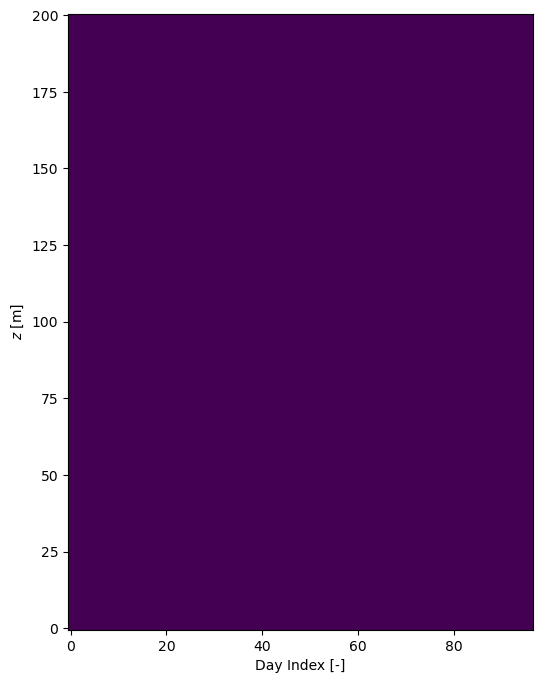

In [15]:
fig,ax = plt.subplots(figsize = (6, 8))

cntf = ax.pcolormesh(np.linspace(0, 96, 96), np.linspace(0, 200, 200), mmm['x'][5,:,:].T)
ax.set_ylabel("$z$ [m]")
ax.set_xlabel("Day Index [-]")